In [2]:
# https://insidelearningmachines.com/implement-the-bootstrap-method-in-python/

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import make_regression
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error,mean_squared_error

import openpyxl
from pathlib import Path

In [7]:
## function to generate bootstrap datasets ##
def make_bootstraps(data,n_bootstraps=100):
    #initialize output dictionary & unique value count
    dc   = {}
    unip = 0
    #get sample size
    b_size = data.shape[0]
    #get list of row indexes
    idx = [i for i in range(b_size)]
    #loop through the required number of bootstraps
    for b in range(n_bootstraps):
        #obtain boostrap samples with replacement
        sidx   = np.random.choice(idx,replace=True,size=b_size)
        b_samp = data[sidx,:]
        #compute number of unique values contained in the bootstrap sample
        unip  += len(set(sidx))
        #obtain out-of-bag samples for the current b
        oidx   = list(set(idx) - set(sidx))
        o_samp = np.array([])
        if oidx:
            o_samp = data[oidx,:]
        #store results
        dc['boot_'+str(b)] = {'boot':b_samp,'test':o_samp}
    #state the mean number of unique values in the bootstraps
    print('Mean number of unique values in each bootstrap: {:.2f}'.format(unip/n_bootstraps))
    #return the bootstrap results
    return(dc)

In [8]:
## function determining the dependence on training size for our model ##
def error_by_trainsize(train,test,train_size,iters=10):
    #initialize model
    lr    = LinearRegression()
    maes  = np.array([])
    mses  = np.array([])
    #get list of row indexes
    idx = [i for i in range(train.shape[0])]
    #loop over each training size
    for ts in train_size:
        #initialize error metrics
        mae = 0
        mse = 0
        #for each training size, I will repeat the calculation iters times
        for j in range(iters):
            #obtain training samples without replacement
            sidx     = np.random.choice(idx,replace=False,size=ts)
            trainset = np.copy(train[sidx,:])
            #fit a linear regression model to the training set
            lr.fit(trainset[:,0].reshape(-1,1),trainset[:,1].reshape(-1,1))
            #generate predictions & calculate error metrics
            yp  = lr.predict(test[:,0].reshape(-1,1))
            mae += mean_absolute_error(test[:,1],yp)
            mse += mean_squared_error(test[:,1],yp) 
        #store the mean error metrics over all repetitions
        mae = np.array([mae/iters])
        mse = np.array([mse/iters])
        maes = np.concatenate((maes,mae))
        mses = np.concatenate((mses,mse))
    #return error metrics
    return(maes,mses)

In [21]:
planilha_diogo = Path('D:/amigos/diogo_jirau/Nano_Hyperspec_Chl-a_bootstrap.xlsx')
wb = openpyxl.load_workbook(planilha_diogo)

# Get the sheet containing the data
ws = wb['RMSE_linear']

# Create a dictionary of column names
# https://stackoverflow.com/questions/51478413/select-a-column-by-its-name-openpyxl/51581162
ColNames = {}
Current = 0
for COL in ws.iter_cols(1, ws.max_column):
    ColNames[COL[0].value] = Current
    Current += 1

band_ratio_col_pos = ColNames['716/676']
chla_column_position = ColNames['Chl-a']

bdr_lst = []
chl_lst = []

# iterate over every row ignoring the first one because it only contains the name labels
for row in ws.iter_rows(min_row=2, min_col=None, max_col=None):
    # get the quality flag for the given row
    bandRatio = row[band_ratio_col_pos]
    chla = row[chla_column_position]
    bdr_lst.append([bandRatio.value]) 
    chl_lst.append([chla.value])

print(f'716/676 (size {len(bdr_lst)}) : \n{bdr_lst}\n') 
print(f'Chl-a (size {len(chl_lst)}) : \n{chl_lst}')

716/676 (size 18) : 
[[1.12648221343874], [1.26190294964807], [1.90909090909091], [1.2896174863388], [2.10576923076923], [2.765625], [0.92274678111588], [1.92926628868179], [2.85470221955832], [3.315], [0.802884615384616], [1.53333333333333], [2.68840579710145], [3.02], [1.28571428571429], [2.22598870056497], [1.74528301886792], [0.984802431610942]]

Chl-a (size 18) : 
[[22.8583333333333], [46.6516666666667], [107.9], [49.344], [119.855], [144.155555555556], [14.2946153846154], [152.99115942029], [177.969166666667], [245.854827586207], [17.7566666666667], [86.2342857142857], [244.1], [290.7], [68.9975], [135.776666666667], [130.406428571429], [38.2866666666667]]


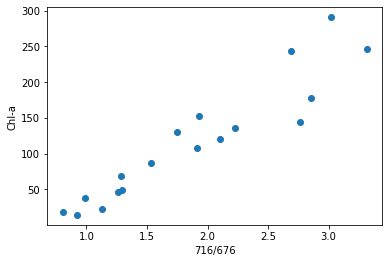

In [22]:
plt.scatter(bdr_lst,chl_lst)
plt.xlabel('716/676')
plt.ylabel('Chl-a')
plt.show()

In [24]:
np.array(bdr_lst)

array([[1.12648221],
       [1.26190295],
       [1.90909091],
       [1.28961749],
       [2.10576923],
       [2.765625  ],
       [0.92274678],
       [1.92926629],
       [2.85470222],
       [3.315     ],
       [0.80288462],
       [1.53333333],
       [2.6884058 ],
       [3.02      ],
       [1.28571429],
       [2.2259887 ],
       [1.74528302],
       [0.98480243]])

In [25]:
bootstrapped_bdr_lst = make_bootstraps(np.array(bdr_lst), n_bootstraps=30)

Mean number of unique values in each bootstrap: 11.23


In [26]:
bootstrapped_bdr_lst

{'boot_0': {'boot': array([[0.80288462],
         [2.2259887 ],
         [3.02      ],
         [1.92926629],
         [2.85470222],
         [1.12648221],
         [1.12648221],
         [0.80288462],
         [1.92926629],
         [2.6884058 ],
         [2.6884058 ],
         [1.92926629],
         [1.28571429],
         [0.98480243],
         [3.02      ],
         [2.2259887 ],
         [3.02      ],
         [2.10576923]]),
  'test': array([[1.26190295],
         [1.90909091],
         [1.28961749],
         [2.765625  ],
         [0.92274678],
         [3.315     ],
         [1.53333333],
         [1.74528302]])},
 'boot_1': {'boot': array([[2.2259887 ],
         [1.28571429],
         [1.12648221],
         [3.315     ],
         [2.6884058 ],
         [0.80288462],
         [1.26190295],
         [2.10576923],
         [2.2259887 ],
         [2.765625  ],
         [1.12648221],
         [2.10576923],
         [0.80288462],
         [1.26190295],
         [2.765625  ],
        